<a href="https://colab.research.google.com/github/barkhahbpp/sistem-cerdas/blob/main/bert_small_L6_H512_A8_userstory_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Install Dependencies #

In [1]:
!pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 125.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 103.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.14.1
  Attempting uninstall: tensorflow
    Found existing insta

In [2]:
!pip install pyyaml h5py

# 2 Data #

## 2.1 Loading Data ##

In [3]:
import os

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(tf.version.VERSION)

2.15.0


In [4]:
dataseturl = 'https://raw.githubusercontent.com/barkhahbpp/deepsedataset/main/sp_dataset/marked_data/moodle.csv'
userstory_df = pd.read_csv(dataseturl)
userstory_df

,issuekey,title,description,storypoint,split_mark
0,MDL-1626,Forum: Per-discussion subscription,I am finding that my inbox is absolutely flood...,100,train
1,MDL-3714,Forum: Reply by e-mail,How about the ability to post to the forums vi...,100,train
2,MDL-5583,allow teachers to specify certain fields in da...,"When creating a database, allow the teacher to...",20,train
3,MDL-8501,Forum: proceed to next thread link,Please put a link to jump to the next thread i...,20,train
4,MDL-10115,A use profile's course list is arbitarily limi...,"When viewing a user's profile, if the list of ...",13,train
...,...,...,...,...,...
1161,MDL-54984,Final deprecation / removal of MUC stuff depre...,"From [~mr-russ], in devs chat: {quote} As ...",1,test
1162,MDL-54988,Final deprecation of methods from lib/modinfol...,"I found is_user_access_restricted_by_group(), ...",1,test
1163,MDL-55066,Create a script to compare all grades for a 57...,Currently the upgrade step for checking if a c...,2,test
1164,MDL-55126,Deprecated get_records_csv() and put_records_c...,While searching for php 7.1 incompatible code ...,1,test


In [5]:
userstory_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166 entries, 0 to 1165
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   issuekey     1166 non-null   object
 1   title        1166 non-null   object
 2   description  1166 non-null   object
 3   storypoint   1166 non-null   int64 
 4   split_mark   1166 non-null   object
dtypes: int64(1), object(4)
memory usage: 45.7+ KB


## 2.2 Explanatory Data Analisys ##

### 2.2.1 Splitting Strategy Overview

Overviewing split strategy according to dataset. Dataset author split dataset into three category split marks. first, test set, second, train set and third, validation set.

In [6]:
split_strategy = userstory_df.groupby('split_mark').agg('count')
split_strategy['sum'] = split_strategy['issuekey'].sum()
split_strategy['percent'] = (split_strategy['issuekey']/split_strategy['issuekey'].sum()*100)

split_strategy['datacount'] = split_strategy['issuekey']
split_strategy = split_strategy.drop(['issuekey',	'title',	'description',	'storypoint'], axis=1)
split_strategy

,sum,percent,datacount
split_mark,,,
test,1166,20.068611,234
train,1166,59.948542,699
val,1166,19.982847,233


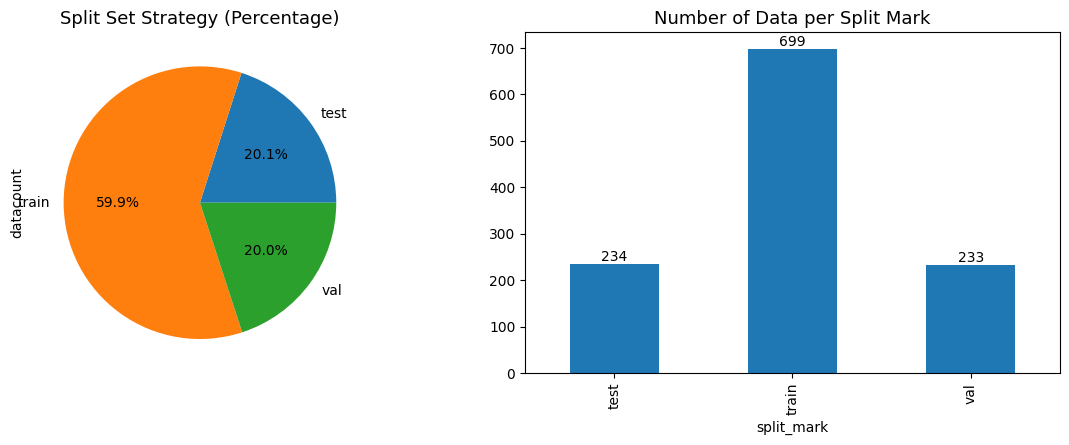

In [7]:
# Split Strategy Overview
fig, axes = plt.subplots(ncols=2, figsize=(12, 4), dpi=100)
plt.tight_layout()

split_strategy['datacount'].plot(ax=axes[0],kind="pie", autopct="%.1f%%")
split_strategy['datacount'].plot(ax=axes[1],kind="bar")

for container in axes[1].containers:
  axes[1].bar_label(container)

axes[0].set_title('Split Set Strategy (Percentage)', fontsize=13)
axes[1].set_title('Number of Data per Split Mark', fontsize=13)

plt.show()
# fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

### 2.2.2 Descriptive Analysis of Dataset ###

Generate descriptive statistic of dataset. Information about number of character and number of token from dataset will be calculated and evaluated

In [8]:
# calculate number of token and character from the text
# number of character
userstory_df['numofchars'] = userstory_df['title'].str.len()

# number of word tokens
userstory_df['numofwords'] = userstory_df['title'].str.split().map(lambda x: len(x))
userstory_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166 entries, 0 to 1165
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   issuekey     1166 non-null   object
 1   title        1166 non-null   object
 2   description  1166 non-null   object
 3   storypoint   1166 non-null   int64 
 4   split_mark   1166 non-null   object
 5   numofchars   1166 non-null   int64 
 6   numofwords   1166 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 63.9+ KB


In [9]:
userstory_df

,issuekey,title,description,storypoint,split_mark,numofchars,numofwords
0,MDL-1626,Forum: Per-discussion subscription,I am finding that my inbox is absolutely flood...,100,train,34,3
1,MDL-3714,Forum: Reply by e-mail,How about the ability to post to the forums vi...,100,train,22,4
2,MDL-5583,allow teachers to specify certain fields in da...,"When creating a database, allow the teacher to...",20,train,73,11
3,MDL-8501,Forum: proceed to next thread link,Please put a link to jump to the next thread i...,20,train,34,6
4,MDL-10115,A use profile's course list is arbitarily limi...,"When viewing a user's profile, if the list of ...",13,train,85,15
...,...,...,...,...,...,...,...
1161,MDL-54984,Final deprecation / removal of MUC stuff depre...,"From [~mr-russ], in devs chat: {quote} As ...",1,test,58,10
1162,MDL-54988,Final deprecation of methods from lib/modinfol...,"I found is_user_access_restricted_by_group(), ...",1,test,52,6
1163,MDL-55066,Create a script to compare all grades for a 57...,Currently the upgrade step for checking if a c...,2,test,72,13
1164,MDL-55126,Deprecated get_records_csv() and put_records_c...,While searching for php 7.1 incompatible code ...,1,test,50,4


In [10]:
userstory_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
storypoint,1166.0,15.538593,21.645639,1.0,3.0,8.0,20.0,100.0
numofchars,1166.0,56.014580,19.981080,15.0,43.0,53.0,67.0,158.0
numofwords,1166.0,8.596055,3.376864,2.0,6.0,8.0,11.0,24.0


### 2.2.3 Distribution

Probability Distribution of number of characters data, number of words data, and story point data.

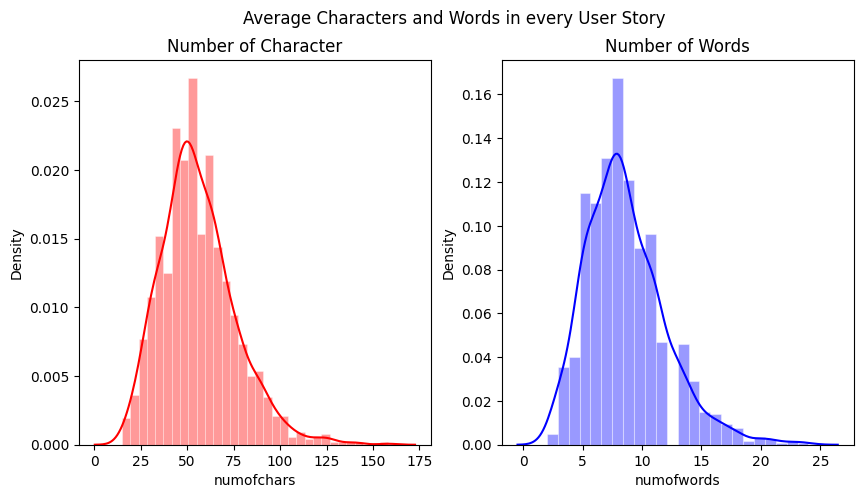

In [11]:
import seaborn as sns

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

sns.histplot(userstory_df.numofchars.map(lambda x: np.mean(x)), ax=ax1, color="red", kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
ax1.set_title('Number of Character')

sns.histplot(userstory_df.numofwords.map(lambda x: np.mean(x)), ax=ax2, color="blue", kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
ax2.set_title('Number of Words')

fig.suptitle('Average Characters and Words in every User Story')

plt.show()
# userstory_df['storypoint'].plot(kind='hist', bins=20, title='storypoint')
# plt.gca().spines[['top', 'right',]].set_visible(False)

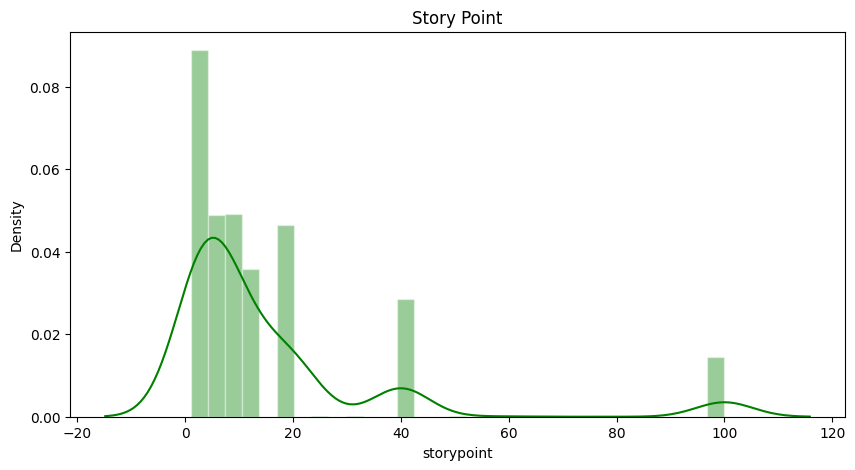

In [12]:
fig,ax=plt.subplots(1,1,figsize=(10,5))

sns.histplot(userstory_df.storypoint.map(lambda x: np.mean(x)), ax=ax, color="green", kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
ax.set_title('Story Point')

plt.show()

## 2.3 Splitting Dataset ##

This section will explain splitting dataset according to three splitmark category namely test, train and validation.

In [41]:
from sklearn.model_selection import train_test_split

test_df = userstory_df[userstory_df['split_mark']=='test']
print("test_df dimention :"+str(test_df.shape))

train_df = userstory_df[userstory_df['split_mark']=='train']
print("train_df dimention :"+str(train_df.shape))

val_df = userstory_df[userstory_df['split_mark']=='val']
print("val_df dimention :"+str(val_df.shape))

X_val, X_test, y_val, y_test = train_test_split(train_df['title'], train_df['storypoint'], test_size=0.6, random_state=4)

test_df dimention :(234, 7)
train_df dimention :(699, 7)
val_df dimention :(233, 7)


### 2.3.1 Distribution of Number of Characters of Every Dataset ###

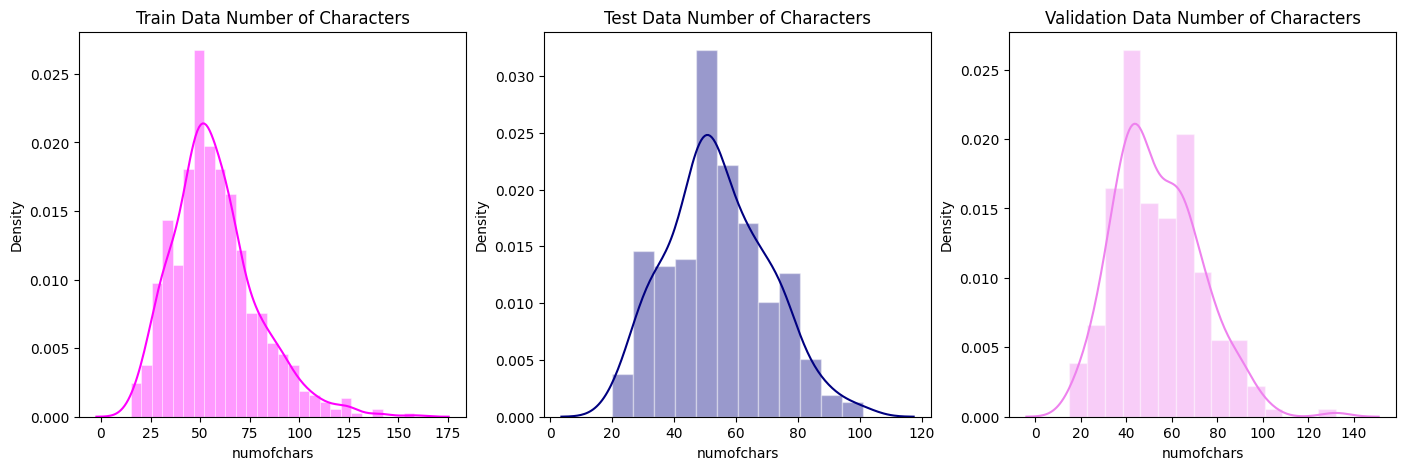

In [42]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(17,5))

sns.histplot(train_df.numofchars.map(lambda x: np.mean(x)), ax=ax1, color="magenta", kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
ax1.set_title('Train Data Number of Characters')

sns.histplot(test_df.numofchars.map(lambda x: np.mean(x)), ax=ax2, color="navy", kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
ax2.set_title('Test Data Number of Characters')

sns.histplot(val_df.numofchars.map(lambda x: np.mean(x)), ax=ax3, color="violet", kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
ax3.set_title('Validation Data Number of Characters')

plt.show()

### 2.3.2 Distribution of Number of Words of Every Dataset ###

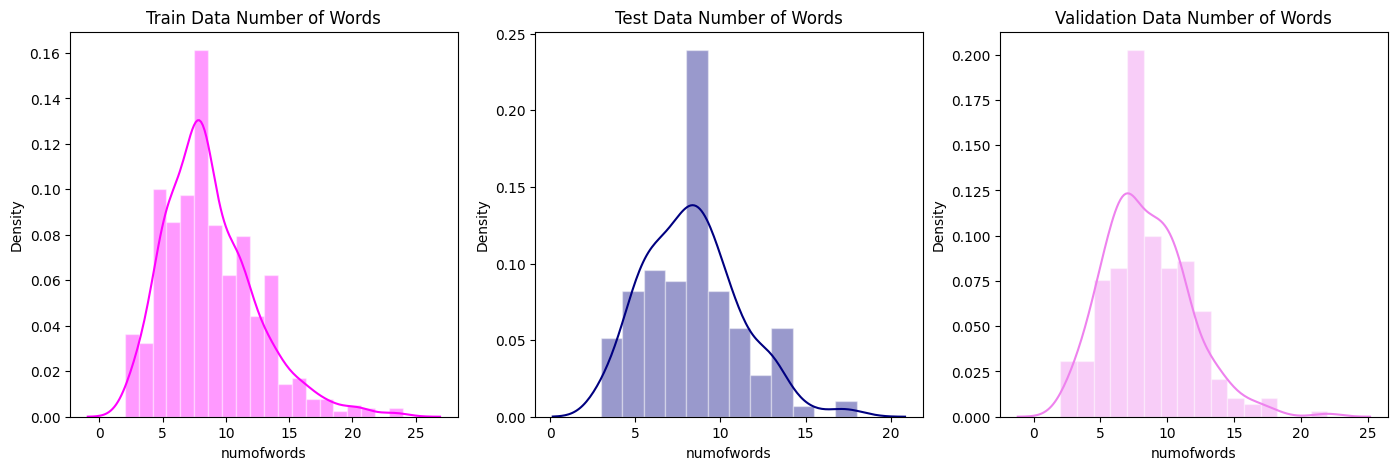

In [43]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(17,5))

sns.histplot(train_df.numofwords.map(lambda x: np.mean(x)), ax=ax1, color="magenta", kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
ax1.set_title('Train Data Number of Words')

sns.histplot(test_df.numofwords.map(lambda x: np.mean(x)), ax=ax2, color="navy", kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
ax2.set_title('Test Data Number of Words')

sns.histplot(val_df.numofwords.map(lambda x: np.mean(x)), ax=ax3, color="violet", kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
ax3.set_title('Validation Data Number of Words')

plt.show()

### 2.3.3 Distribution of Number of Story Point of Every Dataset ###

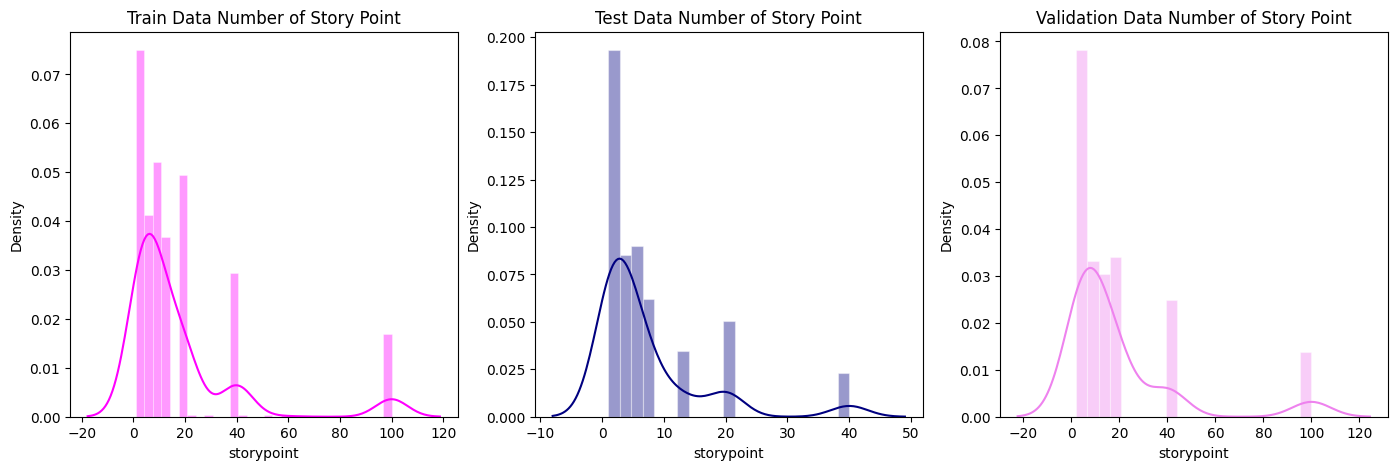

In [44]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(17,5))

sns.histplot(train_df.storypoint.map(lambda x: np.mean(x)), ax=ax1, color="magenta", kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
ax1.set_title('Train Data Number of Story Point')

sns.histplot(test_df.storypoint.map(lambda x: np.mean(x)), ax=ax2, color="navy", kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
ax2.set_title('Test Data Number of Story Point')

sns.histplot(val_df.storypoint.map(lambda x: np.mean(x)), ax=ax3, color="violet", kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
ax3.set_title('Validation Data Number of Story Point')

plt.show()

# 3 Model #

## 3.1 Build Small BERT Model ##

In [45]:
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras import optimizers

In [46]:
# preprocess_url = 'https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3'
# encoder_url = 'https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-l-12-h-768-a-12/versions/4'

preprocess_url = 'https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3'
encoder_url = 'https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-6-h-512-a-8/versions/2'

# Loading Preprocessor and Encoder Model
preprocessor = hub.KerasLayer(preprocess_url)
encoder = hub.KerasLayer(encoder_url, trainable=True)


In [58]:
# BERT Model
text_input_layer = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
encoder_inputs = preprocessor(text_input_layer)
outputs = encoder(encoder_inputs)

# Multilayer Perceptron Model
layer = tf.keras.layers.Dropout(0.7, name="dropout")(outputs['pooled_output'])
layer = tf.keras.layers.Dense(128, activation='relu', name='hidden1')(layer)
layer = tf.keras.layers.Dense(128, activation='relu', name='hidden2')(layer)
layer = tf.keras.layers.Dense(128, activation='relu', name='hidden3')(layer)
layer = tf.keras.layers.Dense(128, activation='relu', name='hidden4')(layer)
layer = tf.keras.layers.Dense(1, activation='linear', name='output')(layer)

#Final Model
model = tf.keras.Model(inputs=[text_input_layer], outputs=[layer])

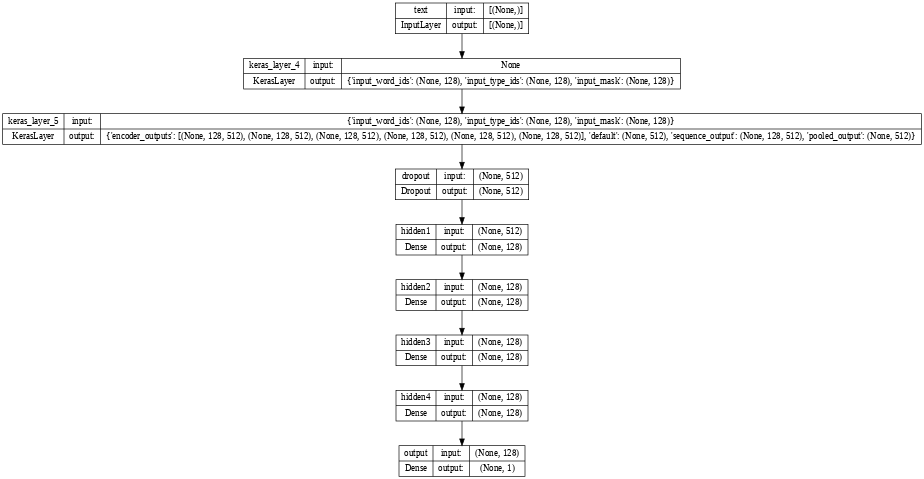

In [59]:
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True, dpi=48)

## 3.2 Define Model Metric ##

In [60]:
METRICS = [
      tf.keras.metrics.MeanAbsoluteError(name='MAE'),
      tf.keras.metrics.RootMeanSquaredError(name='RMSE')
]

initial_rate = 0.0001
end_rate = 1e-8
decay_steps = 10000

learning_rate_fn = optimizers.schedules.PolynomialDecay(
    initial_rate,
    decay_steps,
    end_rate,
    power=0.5)

model.compile(loss='mean_absolute_error',
              optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate_fn),
              metrics=METRICS)

## 3.3 Train Model

### 3.3.1 Fit Model ###

In [61]:
pwd

'/content'

In [62]:
checkpoint_path = "bert_small_L6_H256_A4_userstory_exercise/Checkpoint-{epoch:02d}-{MAE:.02f}.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(train_df['title'], train_df['storypoint'],
                    epochs=200,
                    batch_size=25,
                    verbose=1,
                    validation_data=(val_df['title'], val_df['storypoint']),
                    callbacks=[checkpoint])

Epoch 1/200
28/28 [==============================] - ETA: 0s - loss: 17.1612 - MAE: 17.1612 - RMSE: 28.6997
Epoch 1: loss improved from inf to 17.16120, saving model to bert_small_L6_H256_A4_userstory_exercise/Checkpoint-01-17.16.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 69s 2s/step - loss: 17.1612 - MAE: 17.1612 - RMSE: 28.6997 - val_loss: 18.7112 - val_MAE: 18.7112 - val_RMSE: 30.5184
Epoch 2/200
28/28 [==============================] - ETA: 0s - loss: 16.9812 - MAE: 16.9812 - RMSE: 28.6234
Epoch 2: loss improved from 17.16120 to 16.98116, saving model to bert_small_L6_H256_A4_userstory_exercise/Checkpoint-02-16.98.h5
28/28 [==============================] - 64s 2s/step - loss: 16.9812 - MAE: 16.9812 - RMSE: 28.6234 - val_loss: 18.6039 - val_MAE: 18.6039 - val_RMSE: 30.4588
Epoch 3/200
28/28 [==============================] - ETA: 0s - loss: 16.8434 - MAE: 16.8434 - RMSE: 28.5526
Epoch 3: loss improved from 16.98116 to 16.84342, saving model to bert_small_L6_H256_A4_userstory_exercise/Checkpoint-03-16.84.h5
28/28 [==============================] - 64s 2s/step - loss: 16.8434 - MAE: 16.8434 - RMSE: 28.5526 - val_loss: 18.4934 - val_MAE: 18.4934 - val_RMSE: 30.3979
Epoch 4/200
28/28 [============================

In [63]:
# model save
model.save('bert_small_L6_H256_A4_userstory_exercise.keras')

### 3.3.2 Training Curve ###

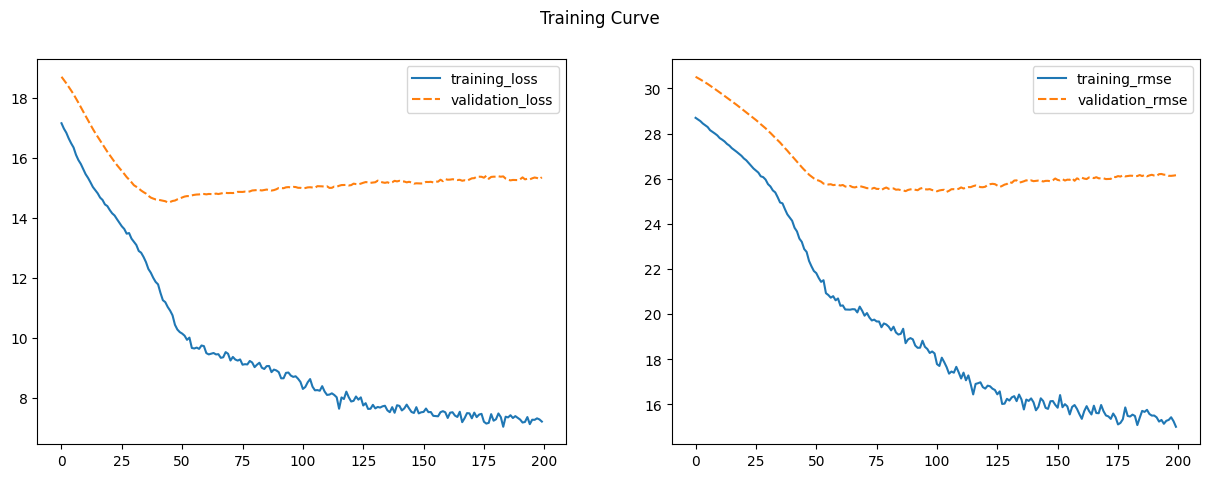

In [64]:
fig, (axs1, axs2) = plt.subplots(1,2,figsize=(15,5))

loss = {
    'training_loss': history.history['loss'],
    'validation_loss': history.history['val_loss']
}

rmse = {
    'training_rmse': history.history['RMSE'],
    'validation_rmse': history.history['val_RMSE']
}

sns.lineplot(loss, ax=axs1, linestyle='solid')
sns.lineplot(rmse, ax=axs2, linestyle='solid')
fig.suptitle("Training Curve")

plt.show()

## 3.4 Predict Story Point ##

In [65]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

pred = model.predict(test_df['title'])

mae = mean_absolute_error(test_df['storypoint'], pred)
mse = mean_squared_error(test_df['storypoint'], pred)
rmse = np.sqrt(mse)

print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)

print("\n pred vs actual :\n")

actualsp = test_df['storypoint'].to_numpy()

for i in range(len(pred)):
  print("pred :"+str(pred[i])+" actual: "+str(actualsp[i])+"\n")


8/8 [==============================] - 7s 755ms/step
Results of sklearn.metrics:
MAE: 7.799300117879851
MSE: 153.10643074430118
RMSE: 12.373618336780119

 pred vs actual :

pred :[9.719036] actual: 20

pred :[1.4136163] actual: 20

pred :[2.6857572] actual: 5

pred :[1.4179829] actual: 8

pred :[12.8337145] actual: 40

pred :[14.951118] actual: 40

pred :[45.414032] actual: 20

pred :[11.18985] actual: 5

pred :[1.4257914] actual: 5

pred :[17.284983] actual: 5

pred :[10.775191] actual: 5

pred :[45.547714] actual: 5

pred :[3.5305057] actual: 13

pred :[7.598895] actual: 8

pred :[1.4258066] actual: 13

pred :[7.930048] actual: 13

pred :[34.37343] actual: 20

pred :[10.41814] actual: 40

pred :[43.344135] actual: 40

pred :[1.5216414] actual: 20

pred :[7.689148] actual: 2

pred :[4.714322] actual: 20

pred :[29.88499] actual: 40

pred :[3.8470488] actual: 8

pred :[1.4230069] actual: 5

pred :[6.763153] actual: 20

pred :[11.253628] actual: 3

pred :[1.4288912] actual: 20

pred :[1